## Effect of Subway Closure on Citibike trips

## Objective: assessing impact on NYC transportation by relating citibike trips by population

In [1]:
! which python


/usr/local/anaconda/bin/python


In [2]:
! python --version

Python 3.6.4 :: Anaconda custom (64-bit)


In [1]:
from __future__ import print_function, division
import pandas as pd
import os
import requests
import shapely
import json
import urllib
from fiona.crs import from_epsg
import scipy as sp
from scipy import stats
import geopy.distance
from getCitiBikeCSV import getCitiBikeCSV # must have this function locally or in path
pd.options.display.max_columns = None
DEVELOPING = False
from get_jsonparsed_data import get_jsonparsed_data # must have this function locally or in path
from evalChisq import evalChisq

In [2]:
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas import GeoDataFrame
from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# IDEA:
## Neighborhoods without subway are more likely to bike to Manhattan than neighborhoods with subway

# NULL HYPOTHESIS:
## The Null hypothesis that the percentage of trips per person in neighborhoods without subway  is the same or higher than the proportion of trips in neighborhoods with subway

# ALTERNATIVE HYPOTHESIS:
## The Null hypothesis that the percentage of trips per person in neighborhoods with subway  is the same or higher than the proportion of trips in neighborhoods without subway

# _$H_0$_ : $\frac{T_{\mathrm{subway}}}{T_{\mathrm{total_pop_in_neighbourhooods_with_subway}}} => \frac{T_{\mathrm{no_subway}}}{T_{\mathrm{total_pop_in_neighbourhooods_without_subway}}}$
# _$H_1$_ : $\frac{T_{\mathrm{subway}}}{T_{\mathrm{total_pop_in_neighbourhooods_with_subway}}} < \frac{T_{\mathrm{no_subway}}}{T_{\mathrm{total_pop_in_neighbourhooods_without_subway}}}$

## I will use a significance level  $\alpha=0.05$

#### which means i want the probability of getting a result at least as significant as mine to be less then 5%

# 1. Data Loading/Wrangling/Jujitsu

## 1.1 Load SUBWAY DATA

In [9]:
subway = urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/arq3-7z49?method=export&format=Shapefile","file.gz")

In [10]:
!unzip file.gz

Archive:  file.gz
  inflating: geo_export_2a55454a-1202-4c09-baba-9634fa707a1e.dbf  
  inflating: geo_export_2a55454a-1202-4c09-baba-9634fa707a1e.shp  
  inflating: geo_export_2a55454a-1202-4c09-baba-9634fa707a1e.shx  
  inflating: geo_export_2a55454a-1202-4c09-baba-9634fa707a1e.prj  


In [3]:
subshp = GeoDataFrame.from_file("geo_export_6ccdb30a-e689-4855-9bc9-47fa2b4855c0.shp")

In [4]:
subshp.head(2)

,line,name,notes,objectid,url,geometry
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (-73.99106999861966 40.73005400028978)
1,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2.0,http://web.mta.info/nyct/service/,POINT (-74.00019299927328 40.71880300107709)


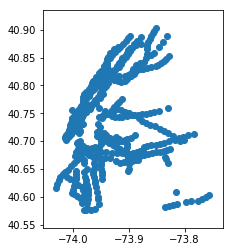

In [5]:
subshp.plot()

### Geopandas geometry _ DONE

## 1.2 Load CITIBIKE_DATA_STATIONS

In [6]:
citibike = pd.read_csv('Clean_Data/citibike_station.csv')

In [7]:
citibike['lonlat'] = list(zip(citibike.lon, citibike.lat))

# 2. Data Processing

In [8]:
print(citibike.shape)
citibike.head()

(818, 7)


,capacity,lat,lon,name,short_name,station_id,lonlat
0,37,40.722174,-73.983688,E 2 St & Avenue B,5515.02,301,"(-73.98368779, 40.72217444)"
1,52,40.727408,-73.981420,E 10 St & Avenue A,5659.05,445,"(-73.98142006, 40.72740794)"
2,34,40.733143,-73.975739,E 20 St & FDR Drive,5886.02,487,"(-73.97573881, 40.73314259)"
3,44,40.732219,-73.981656,1 Ave & E 16 St,5779.08,504,"(-73.98165557, 40.73221853)"
4,39,40.767272,-73.993929,W 52 St & 11 Ave,6926.01,72,"(-73.99392888, 40.76727216)"


In [9]:
citibikegpd = gpd.GeoDataFrame(citibike)

In [10]:
citibikegpd['geometry'] = citibike[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [11]:
citibikegpd.crs = from_epsg(4326)

In [12]:
citibikegpd.to_crs(epsg=2263, inplace = True)

### Geopandas geometry _ DONE

# Extract Manhattan Stations

In [21]:
# Getting the Boroughs shape file from NYC Open Data

In [22]:
url = "https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")



('file.gz', <http.client.HTTPMessage at 0x7fb2f9d78588>)

In [25]:
#Get puidata pathBeautifulSoup
#puidata = os.getenv("PUIDATA")
#if puidata is None:
os.environ["PUIDATA"] = "{}/PUIDATA".format(os.getenv("HOME"))
puidata = os.getenv("PUIDATA")
print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/mv1742/PUIDATA


In [50]:
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /nfshome/mv1742/PUIDATA/geo_export_929f6e64-6e0f-4662-9da0-4d16375cb3cf.dbf  
  inflating: /nfshome/mv1742/PUIDATA/geo_export_929f6e64-6e0f-4662-9da0-4d16375cb3cf.shp  
  inflating: /nfshome/mv1742/PUIDATA/geo_export_929f6e64-6e0f-4662-9da0-4d16375cb3cf.shx  
  inflating: /nfshome/mv1742/PUIDATA/geo_export_929f6e64-6e0f-4662-9da0-4d16375cb3cf.prj  


In [51]:
boro = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                                 "/geo_export_929f6e64-6e0f-4662-9da0-4d16375cb3cf.shp")

In [211]:
boro.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
index_left,,,,,
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...
1,2.0,Bronx,1.186615e+09,463464.521828,(POLYGON ((1012821.805786134 229228.2645873486...
2,5.0,Staten Island,1.623921e+09,330432.867999,(POLYGON ((970217.0223998993 145643.3322142987...
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((1021176.479003908 151374.7969970215...
4,4.0,Queens,3.044772e+09,895228.960360,(POLYGON ((1029606.076599121 156073.8142089235...


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


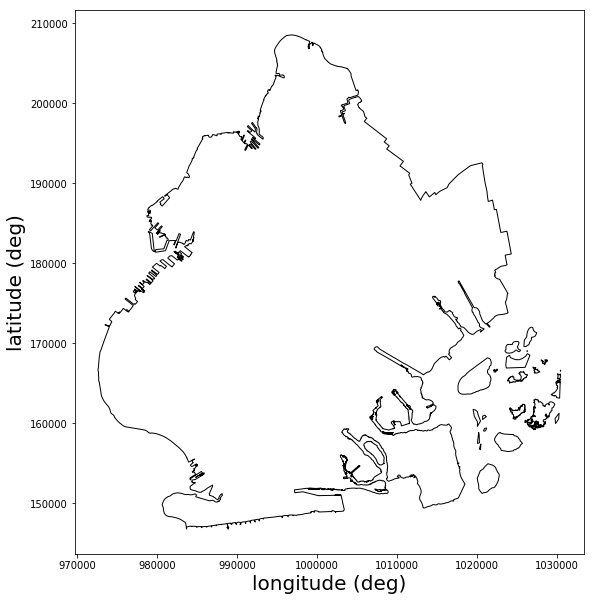

In [212]:
bk = boro[(boro.boro_name == 'Brooklyn')]
ax = bk.plot(column='puma', color="w", edgecolor="k", figsize=(10,10))
ax.set_xlabel("longitude (deg)", fontsize=20)
ax.set_ylabel("latitude (deg)", fontsize=20);

In [52]:
boro.crs

{'init': 'epsg:4326'}

In [53]:
boro.to_crs(epsg=2263, inplace=True)

In [54]:
subshp.to_crs(epsg=2263, inplace=True)

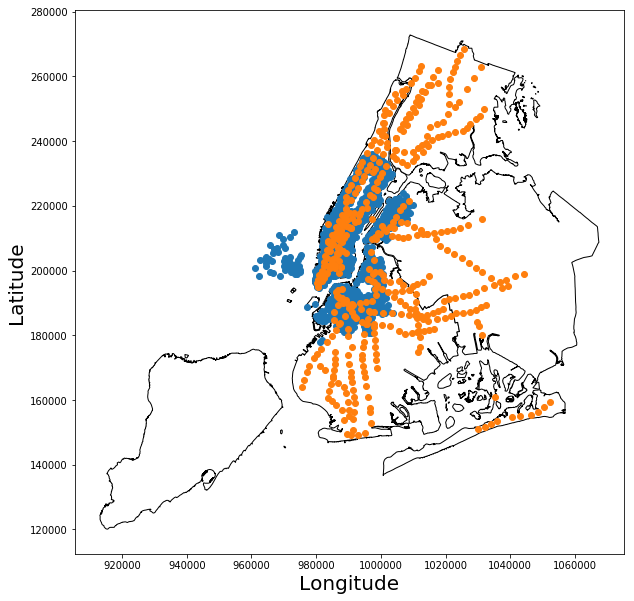

In [221]:
ax = boro.plot(facecolor="w", edgecolor="k",figsize=(10,10))
citibikegpd.plot(ax=ax)
subshp.plot(ax=ax)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20);

In [56]:
### Figure 1. Citibike stations, Subway Stations in Manhattan

In [57]:
boro_citi = gpd.sjoin(boro, citibikegpd, op="contains")

In [213]:
#boro_citi

In [59]:
man_brstations = boro_citi[boro_citi.boro_name=='Brooklyn']
print(man_brstations.shape)
man_brstations.head(2)

(267, 13)


,boro_code,boro_name,shape_area,shape_leng,geometry,index_right,capacity,lat,lon,name,short_name,station_id,lonlat
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((1021176.479003908 151374.7969970215...,327,31,40.717746,-73.956001,N 8 St & Driggs Ave,5340.05,3090,"(-73.95600096, 40.71774592)"
3,3.0,Brooklyn,1.937567e+09,739945.437431,(POLYGON ((1021176.479003908 151374.7969970215...,329,27,40.719009,-73.958525,Berry St & N 8 St,5379.09,3092,"(-73.95852515, 40.7190095)"


In [60]:
man_citistations = boro_citi[boro_citi.boro_code==1]
print(man_citistations.shape)
man_citistations.head(2)

(418, 13)


,boro_code,boro_name,shape_area,shape_leng,geometry,index_right,capacity,lat,lon,name,short_name,station_id,lonlat
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,369,59,40.765005,-73.958185,1 Ave & E 68 St,6822.09,3141,"(-73.95818491, 40.76500525)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,383,37,40.766638,-73.953483,E 72 St & York Ave,6889.12,3156,"(-73.95348296, 40.76663814)"


In [61]:
# Manhanttan_stations_done

## 1.3 CITIBIKE_DATA_TRIPS

In [62]:
# download data: a dataset from January 
datestring01 = '201612'
getCitiBikeCSV(datestring01)


file in place, you can continue


In [63]:
# read in data Jan
cb201612 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring01 + '-citibike-tripdata.csv')
cb201612.tail(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
812190,951,2016-12-31 23:59:31,2017-01-01 00:15:23,3158,W 63 St & Broadway,40.771639,-73.982614,3169,Riverside Dr & W 82 St,40.787209,-73.981281,16866,Subscriber,1961.0,1
812191,1322,2016-12-31 23:59:56,2017-01-01 00:21:58,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,25793,Subscriber,1985.0,1


In [64]:
if DEVELOPING:
    cb2016 = cb201612[::1000]
else:
    cb2016 = pd.concat([cb201612, cb201612])

In [65]:
cb2016['date'] = pd.to_datetime(cb2016['Start Time'])
# note that with dataframes I can refer to variables as dictionary keys, 
# i.e. df['starttime'] or as attributes: df.starttime. 
cb2016.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender
count,1.624384e+06,1.624384e+06,1.624384e+06,1.624384e+06,1.624384e+06,1.624384e+06,1.624384e+06,1.624384e+06,1.544976e+06,1.624384e+06
mean,7.759573e+02,1.230659e+03,4.073767e+01,-7.398459e+01,1.210592e+03,4.073718e+01,-7.398458e+01,2.194907e+04,1.977100e+03,1.161004e+00
std,7.542197e+03,1.281955e+03,8.266413e-02,1.430945e-01,1.272932e+03,1.224383e-01,2.177952e-01,3.982456e+03,1.199998e+01,4.893752e-01
min,6.100000e+01,7.200000e+01,0.000000e+00,-7.403137e+01,7.200000e+01,0.000000e+00,-7.404997e+01,1.452900e+04,1.885000e+03,0.000000e+00
25%,3.340000e+02,3.580000e+02,4.072110e+01,-7.399510e+01,3.560000e+02,4.072087e+01,-7.399596e+01,1.835200e+04,NaN,1.000000e+00
50%,5.330000e+02,4.820000e+02,4.073945e+01,-7.398722e+01,4.800000e+02,4.073936e+01,-7.398759e+01,2.270800e+04,NaN,1.000000e+00
75%,8.760000e+02,3.096000e+03,4.075601e+01,-7.397649e+01,3.090000e+03,4.075510e+01,-7.397681e+01,2.565500e+04,NaN,1.000000e+00
max,3.473103e+06,3.440000e+03,4.080421e+01,0.000000e+00,3.440000e+03,4.080421e+01,0.000000e+00,2.734200e+04,2.000000e+03,2.000000e+00


In [66]:
cb2016['End Station ID'] = cb2016['End Station ID'].values.astype(int)
cb2016['Start Station ID'] = cb2016['Start Station ID'].values.astype(int)

In [67]:
cb2016.head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,date
0,528,2016-12-01 00:00:04,2016-12-01 00:08:52,499,Broadway & W 60 St,40.769155,-73.981918,228,E 48 St & 3 Ave,40.754601,-73.971879,26931,Subscriber,1964.0,1,2016-12-01 00:00:04
1,218,2016-12-01 00:00:28,2016-12-01 00:04:06,3418,Plaza St West & Flatbush Ave,40.675021,-73.971115,3358,Garfield Pl & 8 Ave,40.671198,-73.974841,27122,Subscriber,1955.0,1,2016-12-01 00:00:28


In [68]:
cb2016['date'] = pd.to_datetime(cb2016['Start Time'])

In [69]:
#collecting latitude and longitude for later splitting borroughs
latlon = (cb2016[['Start Station Latitude', 
                'Start Station Longitude']].values.astype(float))
print("The number of rows in the 2016 citibike dataset is", len(latlon))
#dropping not needed columns to lighten memory load
#b2016 = cb2016.drop(cb2016.columns[5:-1], axis=1).drop(cb2016.columns[1:3], axis=1)
#cb2016.head()

The number of rows in the 2016 citibike dataset is 1624384


In [70]:
latlon.shape

(1624384, 2)

In [71]:
nstations = pd.DataFrame(latlon).drop_duplicates().shape[0]
print ("number of stations: ", nstations)

number of stations:  609


# 2. Data Processing
## 2.3.1 Filter trips going to Manhattan

In [72]:
man_citistations.head(2)

,boro_code,boro_name,shape_area,shape_leng,geometry,index_right,capacity,lat,lon,name,short_name,station_id,lonlat
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,369,59,40.765005,-73.958185,1 Ave & E 68 St,6822.09,3141,"(-73.95818491, 40.76500525)"
0,1.0,Manhattan,6.366006e+08,361649.881587,(POLYGON ((981219.0557861336 188655.3157958444...,383,37,40.766638,-73.953483,E 72 St & York Ave,6889.12,3156,"(-73.95348296, 40.76663814)"


In [73]:
cb2016['To_Man']=cb2016['End Station ID'].isin(man_citistations.station_id)

In [74]:
#print(cb2016)
cb2016.shape

(1624384, 17)

In [75]:
#cb2016[cb2016['to_Man?']==True]
cb2016_Man=cb2016[cb2016.iloc[:,-1]==True]
print("dataset cb2016 was reduced from ",cb2016.shape[0]," trips to ",cb2016_Man.shape[0])

dataset cb2016 was reduced from  1624384  trips to  1248094


In [76]:
# Sanity check
cb2016_to_Manhattan = cb2016.loc[cb2016['End Station ID'].isin(man_citistations.station_id)]

print("dataset cb2016 was reduced from ",cb2016.shape[0]," trips to ",cb2016_to_Manhattan.shape[0])
cb2016_to_Manhattan.head(2)

dataset cb2016 was reduced from  1624384  trips to  1248094


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,date,To_Man
0,528,2016-12-01 00:00:04,2016-12-01 00:08:52,499,Broadway & W 60 St,40.769155,-73.981918,228,E 48 St & 3 Ave,40.754601,-73.971879,26931,Subscriber,1964.0,1,2016-12-01 00:00:04,True
2,399,2016-12-01 00:00:39,2016-12-01 00:07:19,297,E 15 St & 3 Ave,40.734232,-73.986923,345,W 13 St & 6 Ave,40.736494,-73.997044,19352,Subscriber,1985.0,1,2016-12-01 00:00:39,True


In [77]:
## DO SPATIAL JOIN WITH TAXI ZONE!!

## 1.4 Census data by Census Tract

In [78]:
ctszn = GeoDataFrame.from_file("data/ct_shape.shp")

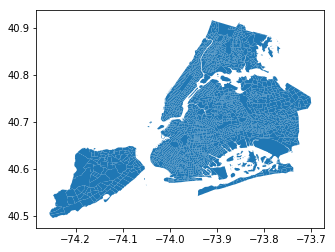

In [79]:
ctszn.plot()

In [80]:
# Figure 2.  Neighbourhoods defined in the  Census Tract 2010

In [81]:
#Upload the main dataset
Census_tracts1=pd.read_csv("data/nyc_census_tracts.csv",index_col=0)
#replace NaN's with zeros
Census_tracts1.fillna(0,inplace=True)#;# SMdata.head()
Census_tracts = Census_tracts1[['TotalPop']]
print(Census_tracts.shape)
Census_tracts.head(2)

(2167, 1)


,TotalPop
CensusTract,
36005000100,7703
36005000200,5403


In [82]:
#Census_tracts['BoroCT2010']

In [83]:
Census_tracts['BoroCT2010']=Census_tracts.index.values

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [84]:
Census_tracts.shape

(2167, 2)

In [85]:
Census_tracts.reset_index(inplace=True)
Census_tracts.head(2) 
#type(Census_tracts.BoroCT2010)

,CensusTract,TotalPop,BoroCT2010
0,36005000100,7703,36005000100
1,36005000200,5403,36005000200


In [86]:
# Find Brooklyn Codes (760 neighbourhoods)
ctszn[ctszn['BoroName']=='Brooklyn'].tail(1)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
2163,3000301,3,Brooklyn,I,000301,3.01,BK09,Brooklyn Heights-Cobble Hill,4004,2.142139e+06,6466.952122,POLYGON ((-73.99429211012634 40.69853508000104...


In [87]:
Census_tracts[(Census_tracts['CensusTract']<36061000100) & (Census_tracts['CensusTract']>36040000000)].head(2)

,CensusTract,TotalPop,BoroCT2010
339,36047000100,4304,36047000100
340,36047000200,1868,36047000200


In [88]:
### NOTE THAT THE SIZE IS THE SAME SO THEY CORRESPOND TO THE SAME SET OF CENSUS TRACT

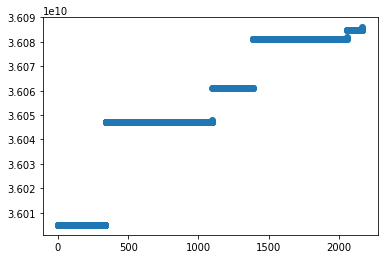

In [89]:
pl.scatter(x=Census_tracts.index.values,y=Census_tracts['CensusTract'].values)

In [90]:
# Figure X. All Census Tract IDs in Socio-economic dataset

In [91]:
# Understand Census Track Records

In [92]:

Census_Br = Census_tracts[(Census_tracts['CensusTract']<36047420100) & (Census_tracts['CensusTract']>36040000000)]
Census_Br=Census_Br.reset_index()
Census_Br.head(2)

,index,CensusTract,TotalPop,BoroCT2010
0,339,36047000100,4304,36047000100
1,340,36047000200,1868,36047000200


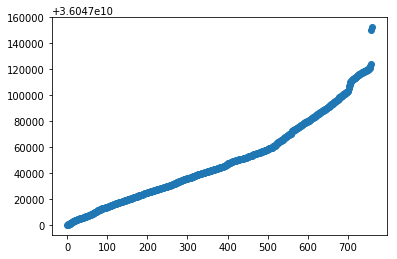

In [93]:
pl.scatter(x=Census_Br.index.values,y=Census_Br['CensusTract'].values)

In [94]:
# Figure X. Census Tract IDs in Brooklyn in Socito_economic dataset

In [95]:
ctszn['BoroCT2010']= ctszn['BoroCT2010'].astype(int)

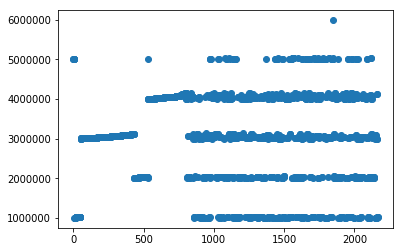

In [96]:
pl.scatter(x=ctszn.index.values,y=ctszn['BoroCT2010'].values)

In [97]:
# Figure X. ALL Census Tract IDs in shape files

In [98]:
ctszn['BoroCT2010'][(ctszn['BoroCT2010']<4000000) & (ctszn['BoroCT2010']>3000000)].shape

(760,)

In [99]:
ctszn_Br = ctszn[(ctszn['BoroCT2010']<4000000) & (ctszn['BoroCT2010']>3000000)]
ctszn_Br.tail(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
2162,3000100,3,Brooklyn,I,000100,1,BK09,Brooklyn Heights-Cobble Hill,4004,2.237282e+06,6527.281839,"POLYGON ((-73.9909320180753 40.70076621604873,..."
2163,3000301,3,Brooklyn,I,000301,3.01,BK09,Brooklyn Heights-Cobble Hill,4004,2.142139e+06,6466.952122,POLYGON ((-73.99429211012634 40.69853508000104...


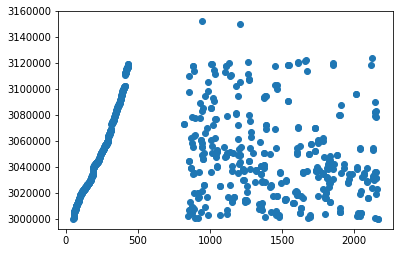

In [100]:
pl.scatter(x=ctszn_Br.index.values,y=ctszn_Br['BoroCT2010'].values)

In [101]:
# Figure X. Census Tract IDs in Brooklyn in shapefiles

In [102]:
# Note that Census tracks for Brooklyn are the same

In [103]:
#df['col1'] = df['col'].str[0:2]
ctszn_Br['Borost'] = ctszn_Br['BoroCT2010'].astype(str)
ctszn_Br['Borost'] = ctszn_Br['Borost'].str[-6:]
ctszn_Br['BoroCT2010'] = ctszn_Br['Borost'].astype(int)
#Census_Br.drop('Borost',axis=1,inplace=True)
ctszn_Br.head(2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to b

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost
52,200,3,Brooklyn,I,000200,2,BK32,Sunset Park West,4012,2.952085e+06,9075.285177,POLYGON ((-74.00628090556296 40.65542951327187...,000200
53,501,3,Brooklyn,I,000501,5.01,BK09,Brooklyn Heights-Cobble Hill,4004,9.015070e+05,4828.170042,POLYGON ((-73.99301822153384 40.69746236456678...,000501


In [104]:
Census_Br['Borost'] = Census_Br['BoroCT2010'].astype(str)
#df['col1'] = df['col'].str[0:2]


In [105]:
Census_Br.head(2)

,index,CensusTract,TotalPop,BoroCT2010,Borost
0,339,36047000100,4304,36047000100,36047000100
1,340,36047000200,1868,36047000200,36047000200


In [106]:
Census_Br['Borost'] = Census_Br['Borost'].str[-6:]

In [107]:
Census_Br['BoroCT2010'] = Census_Br['Borost'].astype(int)
#Census_Br.drop('Borost',axis=1,inplace=True)
Census_Br.head(2)


,index,CensusTract,TotalPop,BoroCT2010,Borost
0,339,36047000100,4304,100,000100
1,340,36047000200,1868,200,000200


In [108]:
print(amax(Census_Br.BoroCT2010))
amin(Census_Br.BoroCT2010)

152200


100

In [109]:
print(amax(ctszn_Br.BoroCT2010))
amin(ctszn_Br.BoroCT2010)

152200


100

# Merge Census_tracts and ctszn

In [110]:
#Census_tracts.BoroCT2010

In [111]:
ctszn_=ctszn_Br.merge(Census_Br,on='BoroCT2010')

In [112]:
print("ctszn_ reduced from ",ctszn.shape,"to",ctszn_.shape)

ctszn_ reduced from  (2166, 12) to (760, 17)


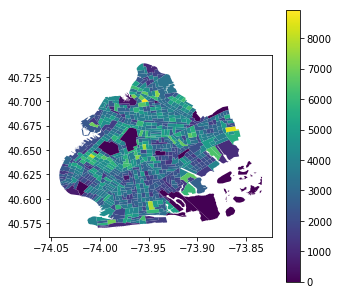

In [113]:
ctszn_.plot(column="TotalPop",figsize=[5,5], legend=True)

In [114]:
# Figure X. Census population per Neighborhood in Brooklyn

In [115]:
subshp.head(2)

,line,name,notes,objectid,url,geometry
0,4-6-6 Express,Astor Pl,"4 nights, 6-all times, 6 Express-weekdays AM s...",1.0,http://web.mta.info/nyct/service/,POINT (986725.0019278985 205255.0527941323)
1,4-6-6 Express,Canal St,"4 nights, 6-all times, 6 Express-weekdays AM s...",2.0,http://web.mta.info/nyct/service/,POINT (984196.5000951464 201155.8398639561)


# Spatial Join with Subway and Citibike Data

In [116]:
boro_Br=boro[(boro.boro_code==3)]
print("boro increased from", boro.shape," to boro_Br shape",boro_Br.shape)

boro increased from (5, 5)  to boro_Br shape (1, 5)


In [117]:
print("ctszn.crs is ",ctszn.crs," ; subshp.crs is " , subshp.crs,\
      "\n citibikegpd.crs",citibikegpd.crs)
#ctszn.crs = from_epsg(4326)

ctszn.crs is  {'init': 'epsg:4326'}  ; subshp.crs is  {'no_defs': True, 'init': 'epsg:2263'} 
 citibikegpd.crs {'no_defs': True, 'init': 'epsg:2263'}


In [118]:
subshp_Br = gpd.sjoin(subshp,boro_Br, op="intersects")
print("subshp shape",subshp.shape," to ", subshp_Br.shape,"boro_Br increased from", boro_Br.shape)

subshp shape (473, 6)  to  (169, 11) boro_Br increased from (1, 5)


In [119]:
citibikegpd_Br = gpd.sjoin(citibikegpd,boro_Br, op="intersects")
print("boro shape",boro.shape,"to boro_Br",boro_Br.shape,"citibikegpd increased from", \
      citibikegpd.shape," to citibikegpd_Br", citibikegpd_Br.shape)

boro shape (5, 5) to boro_Br (1, 5) citibikegpd increased from (818, 8)  to citibikegpd_Br (267, 13)


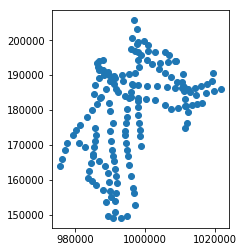

In [120]:
subshp_Br.plot()

In [121]:
# FIgure X. Subway Stations in Brooklyn

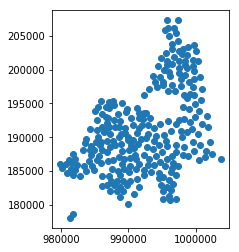

In [122]:
citibikegpd_Br.plot()

In [123]:
# FIgure X. Citibike Stations in Brooklyn

In [124]:
citibikegpd_Br2=citibikegpd_Br.drop('index_right', axis=1)

In [125]:
subshp_Br2=subshp_Br.drop('index_right', axis=1)

In [126]:
print("ctszn_Br.crs is ",ctszn_Br.crs," ; subshp_Br2.crs is " , subshp.crs,\
      "\n citibikegpd_Br2.crs",citibikegpd.crs)
#ctszn.crs = from_epsg(4326)

ctszn_Br.crs is  {'init': 'epsg:4326'}  ; subshp_Br2.crs is  {'no_defs': True, 'init': 'epsg:2263'} 
 citibikegpd_Br2.crs {'no_defs': True, 'init': 'epsg:2263'}


In [127]:
ctszn_Br.to_crs(epsg=2263, inplace=True)
citibikegpd_Br.to_crs(epsg=2263, inplace=True)
subshp_Br.to_crs(epsg=2263, inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


In [149]:
CT_sub_Br = gpd.sjoin(ctszn_Br,subshp_Br2, op="contains")
print("subshp shape",subshp_Br2.shape,"ctszn increased from", ctszn_Br.shape," to ", CT_sub_Br.shape)

subshp shape (169, 10) ctszn increased from (760, 13)  to  (169, 23)


In [150]:
CT_citi_Br = gpd.sjoin(ctszn_Br, citibikegpd_Br2, op="contains")
print("citibikegpd shape",citibikegpd_Br2.shape,"ctszn increased from", ctszn_Br.shape," to ", CT_citi_Br.shape)

citibikegpd shape (267, 12) ctszn increased from (760, 13)  to  (267, 25)


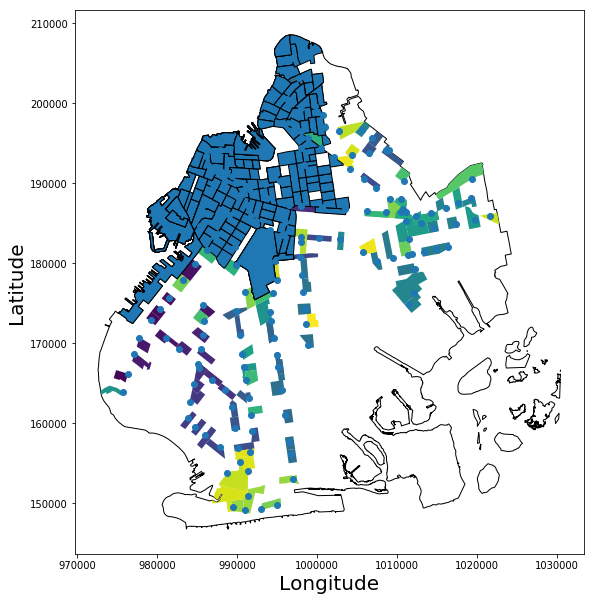

In [222]:
ax =bk.plot(facecolor="w", edgecolor="k",figsize=(10,10))
CT_sub_Br.plot(ax=ax,cmap="viridis",figsize=(10,10), legend=True)
CT_citi_Br.plot(ax=ax, facecolor=None, edgecolor="k")
#citibikegpd_Br.plot(ax=ax)
subshp_Br.plot(ax=ax)
#boro.plot(ax=ax, facecolor="w", edgecolor="k",figsize=(10,10))
ax.set_ylabel("Latitude", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20);

In [152]:
## Figure XXX. The Map above shows the neighborhoods with subway and citibike in Brooklyn

In [153]:
CT_sub_Br.head(1)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost,index_right,line,name,notes,objectid,url,boro_code,boro_name,shape_area,shape_leng
53,501,3,Brooklyn,I,000501,5.01,BK09,Brooklyn Heights-Cobble Hill,4004,901506.992481,4828.170042,"POLYGON ((986185.9869995115 193380.8801879325,...",000501,445,2-3,Clark St,"2-all times, 3-all times exc nights",446.0,http://web.mta.info/nyct/service/,3.0,Brooklyn,1.937567e+09,739945.437431


In [154]:
CT_citi_Br.head(1)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost,index_right,capacity,lat,lon,name,short_name,station_id,lonlat,boro_code,boro_name,shape_area,shape_leng
53,501,3,Brooklyn,I,000501,5.01,BK09,Brooklyn Heights-Cobble Hill,4004,901506.992481,4828.170042,"POLYGON ((986185.9869995115 193380.8801879325,...",000501,148,31,40.697601,-73.993446,Clark St & Henry St,4789.03,391,"(-73.99344559, 40.69760127)",3.0,Brooklyn,1.937567e+09,739945.437431


In [155]:
CT_sub_Br1 = CT_sub_Br[['BoroCT2010','objectid']]

In [156]:
CT_INTERSECTION_C = CT_citi_Br.merge(CT_sub_Br1, on='BoroCT2010',how='outer')
print("CT_citi_Br shape",CT_citi_Br.shape,"CT_citi_Br increased from", CT_INTERSECTION_C.shape," to ", CT_INTERSECTION_C.shape)

CT_citi_Br shape (267, 25) CT_citi_Br increased from (407, 26)  to  (407, 26)


In [215]:
#CT_INTERSECTION_C

In [158]:
# citibikegpd_Br2=CT_sub_Br.drop('index_right', axis=1)
# subshp_Br2=subshp_Br.drop('index_right', axis=1)

# The Citibike stations that do not have a subways and going to Manhattan:::

In [159]:
CITIBIKE_BUT_NO_SUBWAY = CT_INTERSECTION_C[(np.isnan(CT_INTERSECTION_C.objectid))]

In [160]:
# Select Census neighborhoods without Subway

In [161]:
CITIBIKE_BUT_NO_SUBWAY.columns

Index(['BoroCT2010', 'BoroCode', 'BoroName', 'CDEligibil', 'CT2010', 'CTLabel',
       'NTACode', 'NTAName', 'PUMA', 'Shape_Area', 'Shape_Leng', 'geometry',
       'Borost', 'index_right', 'capacity', 'lat', 'lon', 'name', 'short_name',
       'station_id', 'lonlat', 'boro_code', 'boro_name', 'shape_area',
       'shape_leng', 'objectid'],
      dtype='object')

In [162]:
#cbnsgp = cbns.rename({'geometry_y': 'geometry'})

In [163]:
cbnsgp1 = gpd.GeoDataFrame(CITIBIKE_BUT_NO_SUBWAY)

In [164]:
print(type(cbnsgp1))
cbnsgp1.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost,index_right,capacity,lat,lon,name,short_name,station_id,lonlat,boro_code,boro_name,shape_area,shape_leng,objectid
2,6500.0,3,Brooklyn,I,006500,65,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.685634e+06,7861.136622,"POLYGON ((985301.6088256796 187646.6696166366,...",006500,571.0,25.0,40.678356,-74.000145,Clinton St & 4 Place,4119.04,3396.0,"(-74.00014502, 40.6783563)",3.0,Brooklyn,1.937567e+09,739945.437431,NaN
3,6500.0,3,Brooklyn,I,006500,65,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.685634e+06,7861.136622,"POLYGON ((985301.6088256796 187646.6696166366,...",006500,562.0,27.0,40.680959,-73.999057,1 Pl & Clinton St,4193.14,3386.0,"(-73.99905709, 40.6809591)",3.0,Brooklyn,1.937567e+09,739945.437431,NaN


In [165]:
cbnsgp1 = cbnsgp1.rename({'geometry_y': 'geometry'})

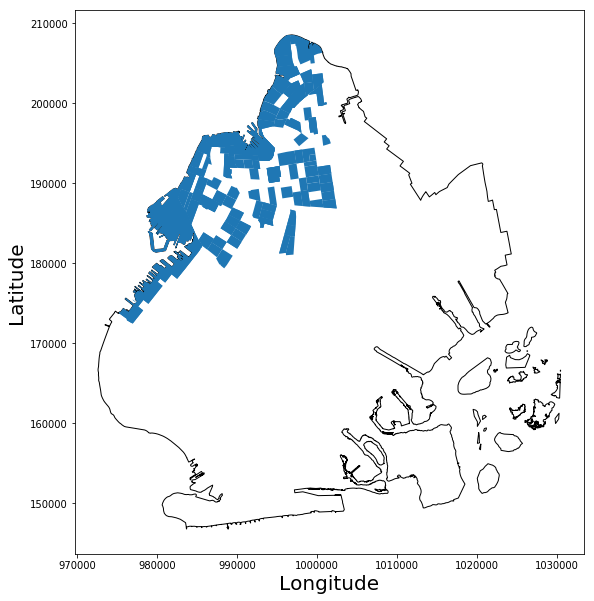

In [223]:
ax =bk.plot(facecolor="w", edgecolor="k",figsize=(10,10))
cbnsgp1.plot(ax=ax)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20);

In [167]:
## Figure XXX. The Map above shows the neighborhoods with NO subway sattions but with citibike stations in Brooklyn

In [168]:
#cbnsgp1['geometry']=cbnsgp1[['geometry_y']].applymap(lambda x:shapely.geometry.Polygon(x))

In [169]:
cbnsgp1.head(1)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost,index_right,capacity,lat,lon,name,short_name,station_id,lonlat,boro_code,boro_name,shape_area,shape_leng,objectid
2,6500.0,3,Brooklyn,I,006500,65,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.685634e+06,7861.136622,"POLYGON ((985301.6088256796 187646.6696166366,...",006500,571.0,25.0,40.678356,-74.000145,Clinton St & 4 Place,4119.04,3396.0,"(-74.00014502, 40.6783563)",3.0,Brooklyn,1.937567e+09,739945.437431,NaN


In [170]:
cb_Br_no_subway = cbnsgp1[['station_id']]

In [171]:
#### Historic Citike Data at neighbourhood with no subway

In [172]:
cb2016_to_Manhattan.head(1)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,date,To_Man
0,528,2016-12-01 00:00:04,2016-12-01 00:08:52,499,Broadway & W 60 St,40.769155,-73.981918,228,E 48 St & 3 Ave,40.754601,-73.971879,26931,Subscriber,1964.0,1,2016-12-01 00:00:04,True


In [173]:
cb2016_to_Manhattan.shape

(1248094, 17)

# The Citibike stations that do have a subways and going to Manhattan:::


In [174]:
CITIBIKE_N_SUBWAY = CT_INTERSECTION_C[(~np.isnan(CT_INTERSECTION_C.objectid))]

In [175]:
cb_s_gp = gpd.GeoDataFrame(CITIBIKE_N_SUBWAY)
print(type(cb_s_gp))
cb_s_gp.head(1)

<class 'geopandas.geodataframe.GeoDataFrame'>


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost,index_right,capacity,lat,lon,name,short_name,station_id,lonlat,boro_code,boro_name,shape_area,shape_leng,objectid
0,501.0,3,Brooklyn,I,000501,5.01,BK09,Brooklyn Heights-Cobble Hill,4004,901506.992481,4828.170042,"POLYGON ((986185.9869995115 193380.8801879325,...",000501,148.0,31.0,40.697601,-73.993446,Clark St & Henry St,4789.03,391.0,"(-73.99344559, 40.69760127)",3.0,Brooklyn,1.937567e+09,739945.437431,446.0


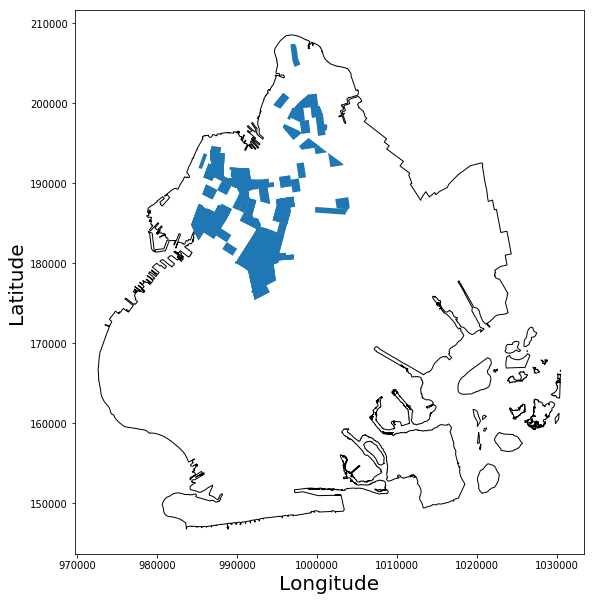

In [224]:
ax =bk.plot(facecolor="w", edgecolor="k",figsize=(10,10))
cb_s_gp1 = cb_s_gp.rename({'geometry_y': 'geometry'})
cb_s_gp1.plot(ax=ax)
ax.set_ylabel("Latitude", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20);

In [177]:
## Figure XXX. The Map above shows the neighborhoods with subway sattions AND with citibike stations in Brooklyn

In [178]:
cb_Br_subway = cb_s_gp1[['station_id']]

### Compare citibike distributions for Subway and No Subway

In [179]:
print("Total Citibike trips in Dec 2016 were: ",cb2016.shape," while trips to Manhattan were:", cb2016_to_Manhattan.shape)
cb2016_to_Manhattan.head(2)

Total Citibike trips in Dec 2016 were:  (1624384, 17)  while trips to Manhattan were: (1248094, 17)


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,date,To_Man
0,528,2016-12-01 00:00:04,2016-12-01 00:08:52,499,Broadway & W 60 St,40.769155,-73.981918,228,E 48 St & 3 Ave,40.754601,-73.971879,26931,Subscriber,1964.0,1,2016-12-01 00:00:04,True
2,399,2016-12-01 00:00:39,2016-12-01 00:07:19,297,E 15 St & 3 Ave,40.734232,-73.986923,345,W 13 St & 6 Ave,40.736494,-73.997044,19352,Subscriber,1985.0,1,2016-12-01 00:00:39,True


## Trips from Neighborhoods with No Subway

In [180]:
# Citibke Trips to Manhattan:
#cb2016_to_Manhattan 
# Station ID from Brooklyn
#cb_Br_no_subway
# Census BT2010 ID to find total population
#cbnsgp


In [181]:
cb2016_to_Manhattan_Br_no_subway = cb2016_to_Manhattan.merge(cb_Br_no_subway,\
                                                             left_on = 'Start Station ID', right_on = 'station_id')
print('cb2016_to_Manhattan  change from ',cb2016_to_Manhattan.shape,\
      ' to cb2016_to_Manhattan_Br_no_subway ' , cb2016_to_Manhattan_Br_no_subway.shape, \
      'cb_Br_subway shape changed from ' ,cb_Br_no_subway.shape)

cb2016_to_Manhattan  change from  (1248094, 17)  to cb2016_to_Manhattan_Br_no_subway  (12874, 18) cb_Br_subway shape changed from  (170, 1)


In [182]:
cb2016_to_Manhattan_Br_no_subway.head(2)

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,date,To_Man,station_id
0,1231,2016-12-01 00:16:23,2016-12-01 00:36:55,2000,Front St & Washington St,40.702551,-73.989402,387,Centre St & Chambers St,40.712733,-74.004607,15384,Customer,NaN,0,2016-12-01 00:16:23,True,2000.0
1,804,2016-12-01 08:38:15,2016-12-01 08:51:39,2000,Front St & Washington St,40.702551,-73.989402,417,Barclay St & Church St,40.712912,-74.010202,25016,Subscriber,1971.0,1,2016-12-01 08:38:15,True,2000.0


In [183]:
total_no_subway = len(cb2016_to_Manhattan_Br_no_subway)
print("total trips with no subway:",total_no_subway)

total trips with no subway: 12874


In [184]:
# As a percentage of the population living in these neighbourhoods this account for X trips per 100 000 people.

In [185]:
print(cbnsgp1.shape)
cbnsgp1.head(2)

(170, 26)


,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Borost,index_right,capacity,lat,lon,name,short_name,station_id,lonlat,boro_code,boro_name,shape_area,shape_leng,objectid
2,6500.0,3,Brooklyn,I,006500,65,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.685634e+06,7861.136622,"POLYGON ((985301.6088256796 187646.6696166366,...",006500,571.0,25.0,40.678356,-74.000145,Clinton St & 4 Place,4119.04,3396.0,"(-74.00014502, 40.6783563)",3.0,Brooklyn,1.937567e+09,739945.437431,NaN
3,6500.0,3,Brooklyn,I,006500,65,BK33,Carroll Gardens-Columbia Street-Red Hook,4005,2.685634e+06,7861.136622,"POLYGON ((985301.6088256796 187646.6696166366,...",006500,562.0,27.0,40.680959,-73.999057,1 Pl & Clinton St,4193.14,3386.0,"(-73.99905709, 40.6809591)",3.0,Brooklyn,1.937567e+09,739945.437431,NaN


In [186]:
cbnsgp_ = cbnsgp1[['BoroCT2010']]
cbnsgp_.head(2)

,BoroCT2010
2,6500.0
3,6500.0


In [187]:
uniquecbnsgp_ = pd.DataFrame(cbnsgp1['BoroCT2010'].unique())
uniquecbnsgp_.rename( columns={0: "BoroCT2010"}, inplace = True)
uniquecbnsgp_.shape

(91, 1)

In [188]:
## Find the total population in this area

In [189]:
ctszn_[['BoroCT2010','TotalPop']].head(2)

,BoroCT2010,TotalPop
0,200,1868
1,501,4759


In [190]:
cb2016_to_Manhattan_Br_no_subway = ctszn_.merge(uniquecbnsgp_,\
                                                             left_on = 'BoroCT2010', right_on = 'BoroCT2010')
print('ctszn_  change from ',ctszn_.shape,\
      ' to cb2016_to_Manhattan_Br_no_subway ' , cb2016_to_Manhattan_Br_no_subway.shape, \
      'cb_Br_subway shape changed from ' ,cb_Br_subway.shape)

ctszn_  change from  (760, 17)  to cb2016_to_Manhattan_Br_no_subway  (91, 17) cb_Br_subway shape changed from  (237, 1)


In [191]:
cb2016_to_Manhattan_Br_no_subway.columns

Index(['BoroCT2010', 'BoroCode', 'BoroName', 'CDEligibil', 'CT2010', 'CTLabel',
       'NTACode', 'NTAName', 'PUMA', 'Shape_Area', 'Shape_Leng', 'geometry',
       'Borost_x', 'index', 'CensusTract', 'TotalPop', 'Borost_y'],
      dtype='object')

In [192]:
cb2016_to_Manhattan_Br_no_subway.shape

(91, 17)

In [193]:
total_no_subway_Pop = cb2016_to_Manhattan_Br_no_subway.TotalPop.sum()
total_no_subway_Pop

334073

In [194]:
print("The total rides per 100 000 inhabitants is: ", total_no_subway_Pop)

The total rides per 100 000 inhabitants is:  334073


In [195]:
total_trips_in_no_subway_per_person = total_no_subway / total_no_subway_Pop 


In [196]:
print("total_trips_in_no_subway_per_person is :",total_trips_in_no_subway_per_person)

total_trips_in_no_subway_per_person is : 0.0385364875342


## Trips from Neighborhoods with Subway

In [197]:
# Citibke Trips to Manhattan:
#cb2016_to_Manhattan 
# Station ID from Brooklyn
#cb_Br_subway

# Census BT2010 ID to find total population
#cb_s_gp


In [198]:
cb2016_to_Manhattan_Br_subway = cb2016_to_Manhattan.merge(cb_Br_subway,\
                                                             left_on = 'Start Station ID', right_on = 'station_id')
print('cb2016_to_Manhattan  change from ',cb2016_to_Manhattan.shape,\
      ' to cb2016_to_Manhattan_Br_no_subway ' , cb2016_to_Manhattan_Br_subway.shape, \
      'cb_Br_subway shape changed from ' ,cb_Br_subway.shape)
cb2016_to_Manhattan_Br_subway.head(2)

cb2016_to_Manhattan  change from  (1248094, 17)  to cb2016_to_Manhattan_Br_no_subway  (10430, 18) cb_Br_subway shape changed from  (237, 1)


,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,date,To_Man,station_id
0,1503,2016-12-01 05:12:43,2016-12-01 05:37:47,3398,Smith St & 9 St,40.674696,-73.997858,304,Broadway & Battery Pl,40.704633,-74.013617,21216,Subscriber,1985.0,1,2016-12-01 05:12:43,True,3398.0
1,1241,2016-12-02 08:25:00,2016-12-02 08:45:42,3398,Smith St & 9 St,40.674696,-73.997858,195,Liberty St & Broadway,40.709056,-74.010434,24139,Subscriber,1978.0,1,2016-12-02 08:25:00,True,3398.0


In [199]:

total_subway = len(cb2016_to_Manhattan_Br_subway)
print("total trips with subway:",total_subway)
#print(cbnsgp.shape)


total trips with subway: 10430


In [200]:
cb_s_gp.head(2)
cb_s_gp_ = cb_s_gp[['BoroCT2010']]
cb_s_gp_.head(2)


,BoroCT2010
0,501.0
1,4100.0


In [201]:
uniquecbnsgp_ns = pd.DataFrame(cb_s_gp_['BoroCT2010'].unique())
uniquecbnsgp_ns.rename( columns={0: "BoroCT2010"}, inplace = True)
uniquecbnsgp_ns.shape


(146, 1)

In [202]:
ctszn_[['BoroCT2010','TotalPop']].head(2)
cb2016_to_Manhattan_Br_subway = ctszn_.merge(uniquecbnsgp_ns,\
                                                             left_on = 'BoroCT2010', right_on = 'BoroCT2010')


In [203]:
print('ctszn_  change from ',ctszn_.shape,\
      ' to cb2016_to_Manhattan_Br_no_subway ' , cb2016_to_Manhattan_Br_subway.shape, \
      'cb_Br_subway shape changed from ' ,cb_Br_subway.shape)

ctszn_  change from  (760, 17)  to cb2016_to_Manhattan_Br_no_subway  (146, 17) cb_Br_subway shape changed from  (237, 1)


In [204]:
total_subway_Pop = cb2016_to_Manhattan_Br_subway.TotalPop.sum()
print('total_subway_Pop', total_subway_Pop)

total_subway_Pop 513736


In [205]:
total_subway_per_person = total_subway / total_subway_Pop 
print("total_subway_per_person is :",total_subway_per_person)


total_subway_per_person is : 0.0203022564119


# Results : 0.0385364875342 (Rides per person without SUBWAY), and 0.0203022564119 (Rides per person with SUBWAY).
## It can be concluded that ridership is greater for locations without subway. Hence the closure of L-train will cause greater Citibike trips.

# Test of proportions can be used using a Chi-square test

|Neighborhood\Ride               |     Trip          | No_Trip          | TOTAL                  
|---------------------------|----------------   |------------------|---------------------------|
| NO_Subway                 | $0.03854*334073$  | $0.9615*334073$  | 334073                    |
| Subway                    | $0.0203*513736$   | $0.9797*513736$  | 513736                    |
|                           |                   |                  |                           |
| TOTAL                     | 23304             |   824505         | 847809                    |


In [206]:
#total trips with no subway: 12874, with a population in these neighborhoods of 334073

    #total trips with subway: 10430, with a population of 513736.

In [207]:
sample_values_riders  = np.array([[0.0385 * 334073, 0.9615* 334073],[0.0203 * 513736, 0.9797 * 513736]])


In [208]:
chisq_riders = evalChisq(sample_values_riders)
DOF = len(sample_values_riders) - 1
print ('chi sq statistics for "Customer riders in workdays": '+
       'chisq = {:.3f}, DOF = {:d}'.format(chisq_riders, DOF))

chi sq statistics for "Customer riders in workdays": chisq = 2509.806, DOF = 1


In [209]:
chimin_alpha5pc = 3.84
print ("The Null hypothesis that the percentage of trips per person in neighborhoods without subway  is the same or higher than the proportion of trips in neighborhoods with subway")
print ("measured as: number of trips per person at each neighborhood from Brooklyn to Manhattan")
print ("neighborhood as defined in Census Tract")
if chisq_riders > chimin_alpha5pc :
    print ("can be rejected at alpha = 0.05")
else: 
    print ("cannot be rejected (p<0.05)")
print ("with a chi square statistics of %.2f"%chisq_riders )

The Null hypothesis that the percentage of trips per person in neighborhoods without subway  is the same or higher than the proportion of trips in neighborhoods with subway
measured as: number of trips per person at each neighborhood from Brooklyn to Manhattan
neighborhood as defined in Census Tract
can be rejected at alpha = 0.05
with a chi square statistics of 2509.81


## NULL HYPOTHESIS:
### The Null hypothesis that the percentage of trips per person in neighborhoods without subway  is the same or higher than the proportion of trips in neighborhoods with subway can be rejected with a confidence greataer than 95%, or with a very low P_value < 0.01.

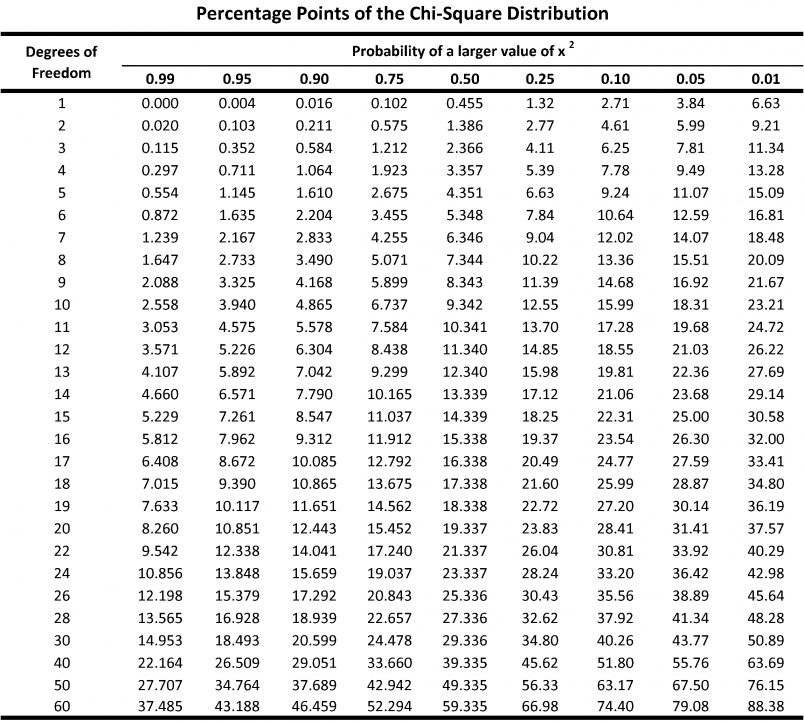

In [210]:
from IPython.display import Image

Image("http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG")